### Steps :
- load dir
- iterate and load the array images
-  

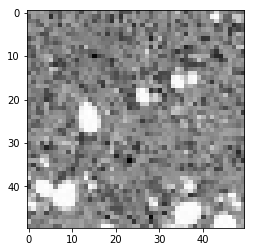

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = 'cancer/'
CATEGORIES = ['invasive_carcinoma', 'non_invasive_carcinoma']


for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

In [7]:
print(img_array.shape)

(50, 50)


[]

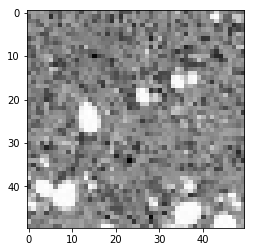

In [8]:
# normalize size of img
IMG_SIZE = 50
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.plot()

In [9]:
# create training datset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        clas_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, clas_num])
            except Exception as e:
                pass
        
create_training_data()

In [10]:
print(len(training_data))

267347


In [14]:
# shuffle the data
import random
import numpy as np

random.shuffle(training_data)

In [15]:
for sample in training_data[:10]:
    print(sample[1])

0
1
1
1
1
0
0
1
1
1


In [16]:
X = []
y = []


for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)   # 1 ==> grayscale


In [17]:
import pickle


pickle_out = open('X_cancer.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_in = open('y_cancer.pickle', 'wb')
pickle.dump(y, pickle_in)
pickle_in.close()

In [19]:
pickle_in = open('X_cancer.pickle', 'rb')
X = pickle.load(pickle_in)

In [20]:
X[1]

array([[[180],
        [181],
        [166],
        ...,
        [239],
        [235],
        [177]],

       [[186],
        [180],
        [170],
        ...,
        [240],
        [236],
        [218]],

       [[163],
        [182],
        [171],
        ...,
        [239],
        [237],
        [228]],

       ...,

       [[177],
        [190],
        [186],
        ...,
        [142],
        [209],
        [182]],

       [[190],
        [184],
        [181],
        ...,
        [182],
        [178],
        [179]],

       [[189],
        [172],
        [193],
        ...,
        [173],
        [194],
        [205]]], dtype=uint8)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

In [22]:
# limit VRAM on GPU for multiple training
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [2]:
pickle_in = open("X_cancer.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y_cancer.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

dense_layers = [1]
layer_sizes = [128]
conv_layers = [1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs_cancer/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=20,
                      validation_split=0.3,
                      callbacks=[tensorboard])

1-conv-128-nodes-1-dense-1552983562
Instructions for updating:
Colocations handled automatically by placer.
Train on 187142 samples, validate on 80205 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
187142/187142 [==============================] - 242s 1ms/sample - loss: 0.4611 - acc: 0.7832 - val_loss: 0.4380 - val_acc: 0.8024
Epoch 2/20
187142/187142 [==============================] - 248s 1ms/sample - loss: 0.4316 - acc: 0.8052 - val_loss: 0.4272 - val_acc: 0.8069
Epoch 3/20
187142/187142 [==============================] - 241s 1ms/sample - loss: 0.4162 - acc: 0.8134 - val_loss: 0.4486 - val_acc: 0.7863
Epoch 4/20
187142/187142 [==============================] - 240s 1ms/sample - loss: 0.4008 - acc: 0.8217 - val_loss: 0.4333 - val_acc: 0.8050
Epoch 5/20
187142/187142 [==============================] - 240s 1ms/sample - loss: 0.3846 - acc: 0.8298 - val_loss: 0.4339 - val_acc: 0.8114
Epoch 6/20
187142/187142 [==============================] - 241s 1ms/sample - loss:

In [6]:
model.save('model_cancer.model')

non_invasive_carcinoma


[]

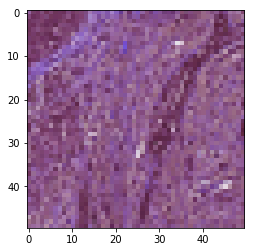

In [7]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

CATEGORIES = ['invasive_carcinoma', 'non_invasive_carcinoma']

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model('model_cancer.model')
invasive = 'invasive.png'
PREDICTIONS = model.predict([prepare(invasive)])
print(CATEGORIES[int(PREDICTIONS[0][0])])

im_array = cv2.imread(invasive, cv2.IMREAD_COLOR)
plt.imshow(im_array)
plt.plot()

non_invasive_carcinoma


[]

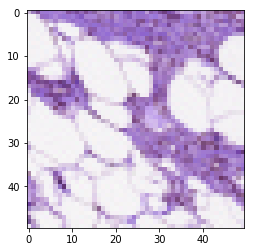

In [8]:
im_pred = 'non_inversive.png'
PREDICTION = model.predict([prepare(im_pred)])
print(CATEGORIES[int(PREDICTION[0][0])])

im_array = cv2.imread(im_pred, cv2.IMREAD_COLOR)
plt.imshow(im_array)
plt.plot()